# The Butterworth & Lanczos Filters
#### by Elizabeth Barnes

Demonstration of how to code and apply (and interpret) Butterworth and Lanczos filters. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (12.0/2, 8.0/2)

# specify whether running on Colab or locally
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
print('IN_COLAB = ' + str(IN_COLAB))

IN_COLAB = False


### Define a function to determine the Lanczos Filter weights to use later in the code

In [2]:
# LANCZOS FILTER
def low_pass_weights(window, cutoff):
    """Calculate weights for a low pass Lanczos filter.

    Args:

    window: int
        The length of the filter window.

    cutoff: float
        The cutoff frequency in inverse time steps.

    """
    order = ((window - 1) // 2 ) + 1
    nwts = 2 * order + 1
    w = np.zeros([nwts])
    n = nwts // 2
    w[n] = 2 * cutoff
    k = np.arange(1., n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2. * np.pi * cutoff * k) / (np.pi * k)
        
    w[n-1:0:-1] = firstfactor * sigma
    w[n+1:-1] = firstfactor * sigma
    
    return w[1:-1]

### Butterworth Filters

In [3]:
# MODIFY THE FREQUENCY CUTOFF AND ORDER
#-------------------------------------------
freq_cutoff = .1          # cutoff for butterworth filter
N1 = 4                    # modify the order of butterworth filter 1
N2 = 9                    # modify the order of butterworth filter 2
N3 = 20                   # modify the order of butterworth filter 3
#-------------------------------------------

In [4]:
# define a frequency array
freq = np.arange(0.,0.51,0.01)

# define omega (radial frequency) and the omega cutoff for filtering
omega = 2.*np.pi*freq
omega_c = freq_cutoff*2*np.pi

#### Response function of a Butterworth filter

Next, we will calculate the squared response functions of Butterworth filters of different _orders_ (N=4,9,30). These will be defined from theory (see lecture notes). The figure below shows what these response functions look like in frequency space.

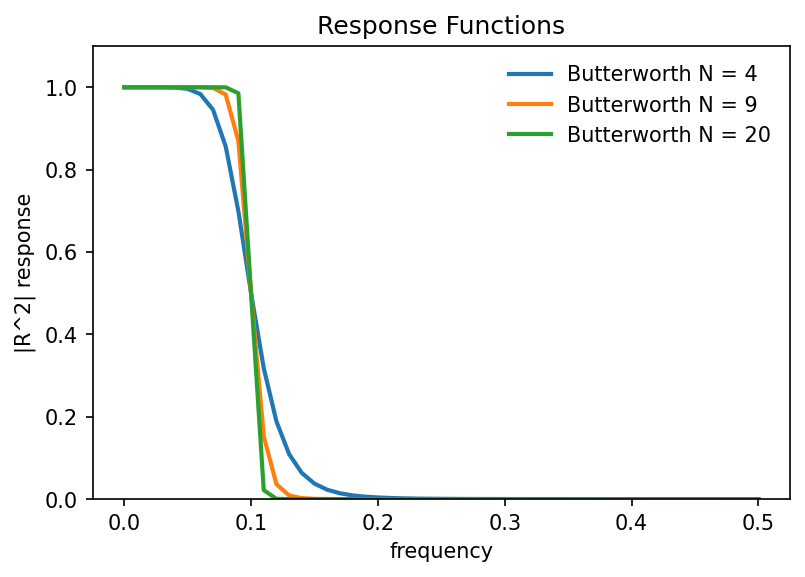

In [5]:
plt.figure()

R2 = 1./(1. + (omega/omega_c)**(2*N1))
plt.plot(freq,R2,'-',linewidth = 2, label = 'Butterworth N = ' + str(N1))

R2 = 1./(1. + (omega/omega_c)**(2*N2))
plt.plot(freq,R2,'-',linewidth = 2, label = 'Butterworth N = ' + str(N2))

R2 = 1./(1. + (omega/omega_c)**(2*N3))
plt.plot(freq,R2,'-',linewidth = 2, label = 'Butterworth N = ' + str(N3))

plt.xlabel('frequency')
plt.ylabel('|R^2| response')
plt.legend(frameon = False)

plt.title('Response Functions')
plt.ylim(0,1.1)
plt.show()

#### Impulse response function of a Butterworth filter
The impulse response shows how a filter spreads the influence of a single observation (time) across the other times. It is as easy as running an array of all zeros and one leading "1" through the filter and plotting the result.

In [6]:
x = np.zeros((300,))
x[0] = 1.

Now, let's plot what this delta function looks like.

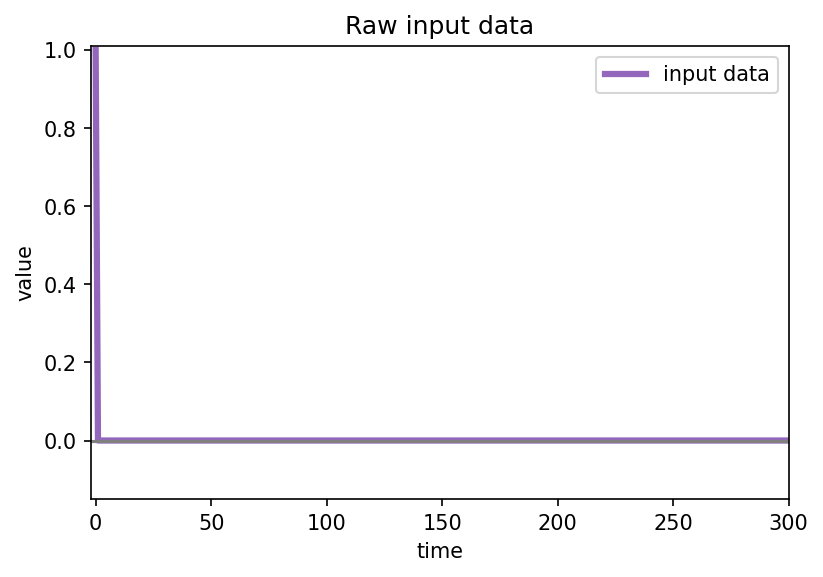

In [7]:
plt.figure()
plt.plot(x, color = 'tab:purple', label='input data', linewidth=3)
plt.axhline(y=0,color='gray')
plt.ylim(-.15,1.01)
plt.xlim(-2,len(x))
plt.xlabel('time')
plt.ylabel('value')
plt.title('Raw input data')
plt.legend()
plt.show()

**Really Important Note**

I just discovered that ```scipy.signal.butter``` defines the frequency cutoff not in terms of frequency, but in terms of double frequency. That is, they say:

"_By default, fs is 2 half-cycles/sample, so these are normalized from 0 to 1, where 1 is the Nyquist frequency. (Wn is thus in half-cycles / sample.)_"

This means when we run sig.butter below, we need to multiply the freq_cutoff by 2!

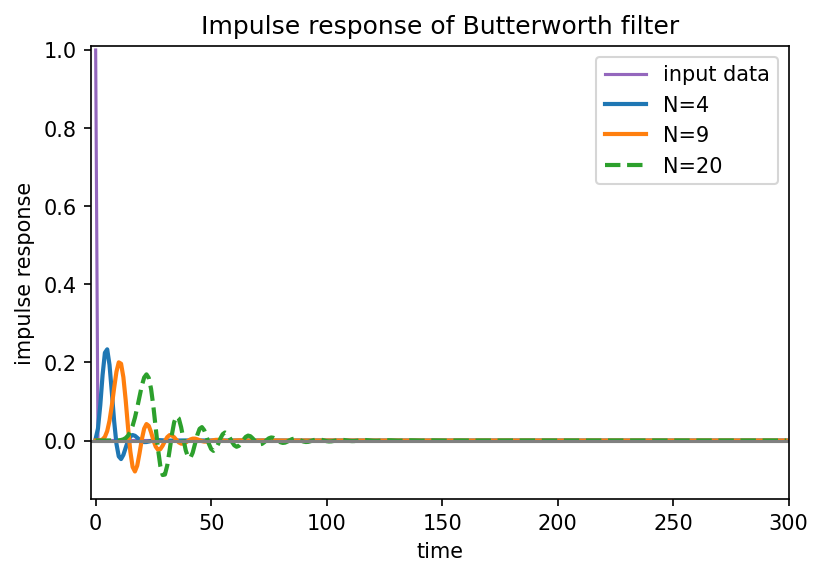

In [8]:
plt.figure()
plt.plot(x, color = 'tab:purple', label='input data')

b, a = sig.butter(N1, freq_cutoff*2)
y = sig.lfilter(b,a,x)
plt.plot(y,'-',color='tab:blue',linewidth = 2, label = 'N=' + str(N1))

b, a = sig.butter(N2, freq_cutoff*2)
y = sig.lfilter(b,a,x)
plt.plot(y,'-',color='tab:orange',linewidth = 2, label = 'N=' + str(N2))

b, a = sig.butter(N3, freq_cutoff*2)
y = sig.lfilter(b,a,x)
plt.plot(y,'--',color='tab:green',linewidth = 2, label = 'N=' + str(N3))

plt.ylim(-.15,1.01)
plt.xlim(-2,len(x))
plt.axhline(y=0,color='gray')

plt.xlabel('time')
plt.ylabel('impulse response')
plt.title('Impulse response of Butterworth filter')

plt.legend()

plt.show()

You can see that the initial impulse is spread over more future times for larger order N. This means that the beginning of your time series can take some time to _spin-up_ when applying a recursive filter, and thus, will likely need to be discarded since it will be corrupt. So, the larger the order N, the tighter your frequency cutoff, but the more data you have to remove from your time series.

#### Butterworth filter applied to red-noise data

Let's apply a Butterworth filter to data that we might actually see in our research, e.g. red noise. First, we need to make the red-noise data (which we all know how to do!). Then, for fun, I'm going to add some cosines to it too to give it some oscillatory frequencies.

In [9]:
np.random.seed(11)

chunk_length = 300
num_chunks= 1
n = chunk_length*num_chunks

# generate red noise time series with autocorrelation
alpha = 0.5
height = 2.0
factor = np.sqrt(1.-alpha*alpha)

x = np.zeros((n,))
pnum = 0

# make red-noise + cosine functions
x[0] = x[-1]*alpha + factor*np.random.randn()
for j in np.arange(1,n):
    x[j] = x[j-1]*alpha + factor*np.random.randn()+1.0*np.cos(2.*np.pi*(1.-0.01*np.random.randn())*52./256.*j)\
    + 0.75*np.cos(2.*np.pi*(1.-.001*np.random.randn())*100./256*j-np.pi/4.)
        
xa = x - np.mean(x)

Plot the results!

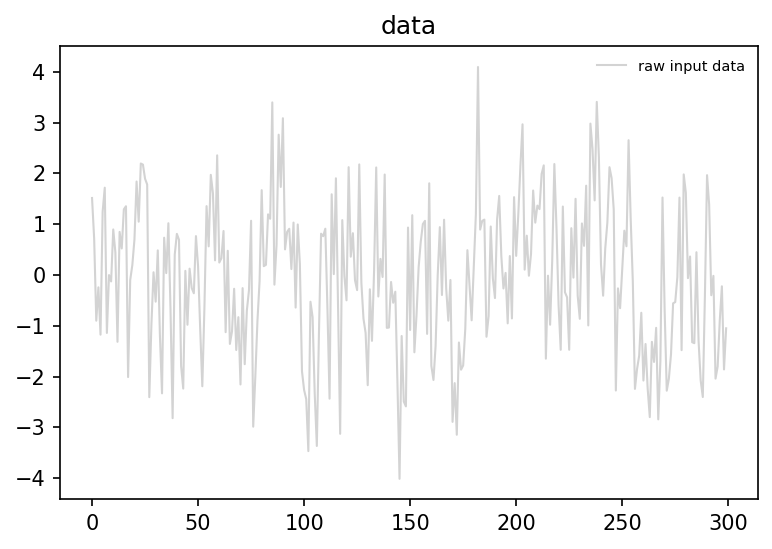

In [10]:
plt.figure()

plt.plot(x,'-',color = 'lightgray',linewidth = 1.0, label = 'raw input data')

plt.title('data')
plt.legend(frameon = False, fontsize = 7)
plt.show()

Apply the filters.

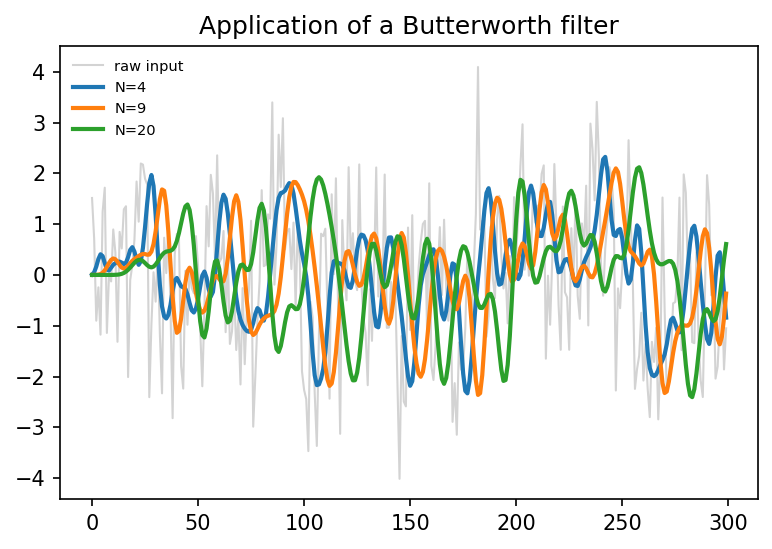

In [11]:
plt.figure()
plt.plot(x,'-',color = 'lightgray',linewidth = 1.0, label = 'raw input')

# filter 1
b, a = sig.butter(N1, freq_cutoff*2)  # create filter with specified cutoff frequency
y = sig.lfilter(b,a,xa)               # apply the filter
plt.plot(y,'-',color = 'tab:blue',linewidth = 2.0, label = 'N=' + str(N1))

# filter 2
b, a = sig.butter(N2, freq_cutoff*2)  # create filter with specified cutoff frequency
y = sig.lfilter(b,a,xa)               # apply the filter
plt.plot(y,'-',color = 'tab:orange',linewidth = 2.0, label = 'N=' + str(N2))

# filter 2
b, a = sig.butter(N3, freq_cutoff*2)  # create filter with specified cutoff frequency
y = sig.lfilter(b,a,xa)               # apply the filter
plt.plot(y,'-',color = 'tab:green',linewidth = 2.0, label = 'N=' + str(N3))


plt.title('Application of a Butterworth filter')

plt.legend(frameon = False, fontsize = 7)
plt.show()

Let's focus on just N1 for now and look at forward-backward filters

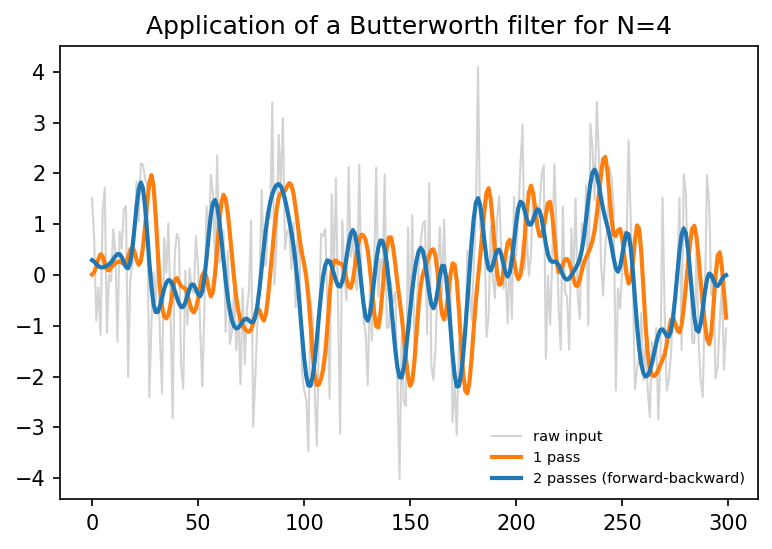

In [12]:
plt.figure()

b, a = sig.butter(N1, freq_cutoff*2)  # create filter with specified cutoff frequency
y = sig.lfilter(b,a,xa)               # apply the filter

plt.plot(x,'-',color = 'lightgray',linewidth = 1.0, label = 'raw input')
plt.plot(y,'-',color = 'tab:orange',linewidth = 2.0, label = '1 pass')

# apply the filter to the filtered data, but backward
y2 = sig.lfilter(b,a,y[::-1])
plt.plot(y2[::-1],'-',color = 'tab:blue',linewidth = 2.0, label = '2 passes (forward-backward)')
y2_butter = np.copy(y2[::-1])

plt.title('Application of a Butterworth filter for N=' + str(N1))

plt.legend(frameon = False, fontsize = 7)
plt.show()

Okay - now let's take _the same time series_ and instead filter it using a 1-2-1 filter (or moving average filter) for comparison.

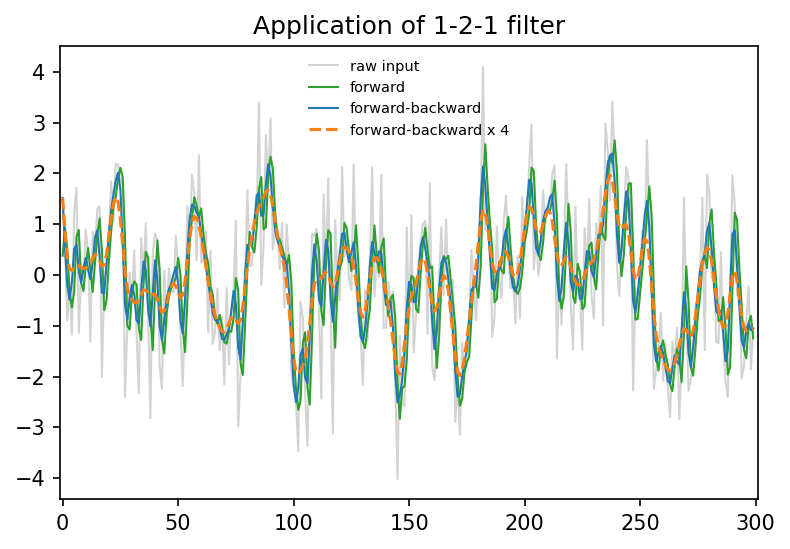

In [13]:
b = (1,2,1)     # define the 1-2-1 kernel

#%% same data, 1-2-1 filter, or moving average filter
plt.figure()
plt.plot(x,'-',color = 'lightgray',linewidth = 1., label = 'raw input')

# create and apply 1-2-1 filter
y = sig.lfilter(b,np.sum(b),x)
plt.plot(y,'-', color = 'tab:green', label = 'forward', linewidth=1.)

# use sig.filtfilt to perform the forward-backward filter all in one go.
y2 = sig.filtfilt(b,np.sum(b),x)
plt.plot(y2,'-',color='tab:blue', label = 'forward-backward', linewidth=1.)

# four times applying the filter, forward-backward twice
y4 = sig.filtfilt(b,np.sum(b),x)
y4 = sig.filtfilt(b,np.sum(b),y4)
y4 = sig.filtfilt(b,np.sum(b),y4)
y4 = sig.filtfilt(b,np.sum(b),y4)
plt.plot(y4,'--',color='tab:orange', label = 'forward-backward x 4')

plt.xlim(-1,np.size(x)+1)
plt.legend(frameon = False, fontsize = 7)
plt.title('Application of 1-2-1 filter')
plt.show()

### Lanczos filter (non-recursive)

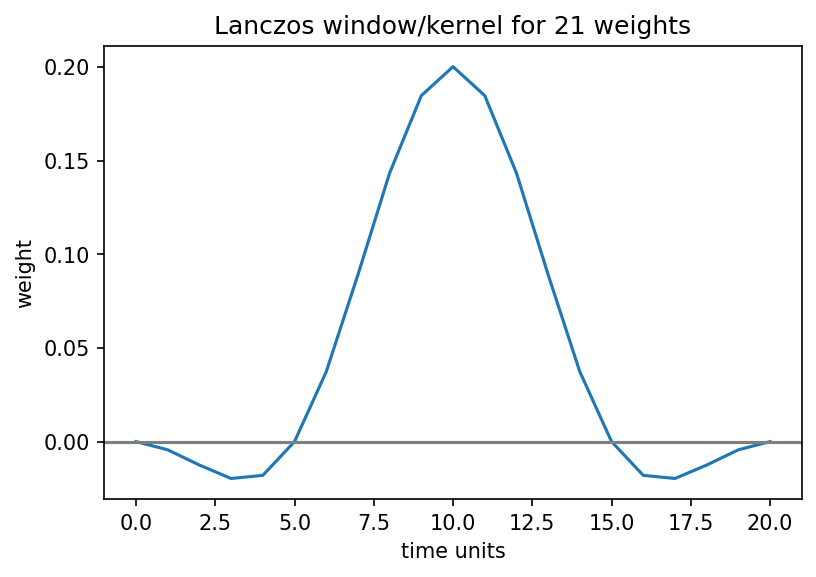

In [14]:
# create Lanczos filter with 21 weights and cutoff at frequency = 1./4. = 0.25
window = 21
wgts = low_pass_weights(window, freq_cutoff)

# plot weights for visualization
plt.figure()
plt.plot(wgts/np.sum(wgts))
plt.axhline(y=0,color='tab:gray')

plt.xlabel('time units')
plt.ylabel('weight')
plt.title('Lanczos window/kernel for ' + str(window) + ' weights')
plt.show()

Now, what happens when we apply this Lanczos filter with 41 weights to our red-noise + cosine time series?

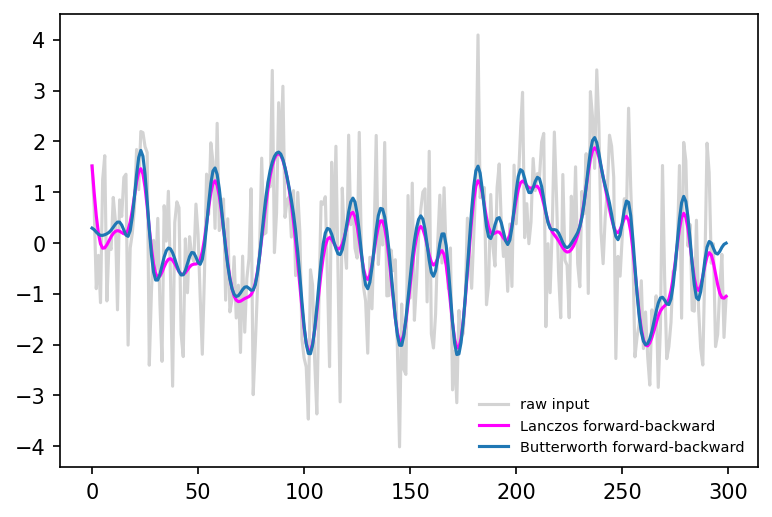

In [15]:
plt.figure()
plt.plot(x,'-',color = 'lightgray',linewidth = 1.5, label = 'raw input')

y2 = sig.filtfilt(wgts,np.sum(wgts),x)
plt.plot(y2, color = 'fuchsia', label = 'Lanczos forward-backward')
plt.plot(y2_butter,'-',color='tab:blue', label = 'Butterworth forward-backward')

plt.legend(frameon = False, fontsize = 7)
plt.show()

For fun, let's take a look at the power spectra of these two smoothed time series

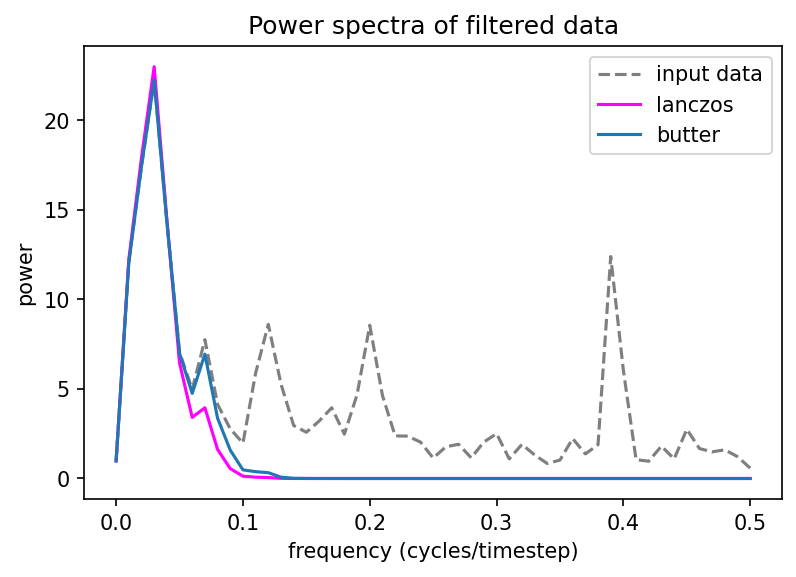

In [18]:
chunkLength = 100

f, p = sig.welch(x, window='hanning', nperseg = chunkLength, noverlap=chunkLength/2.)
plt.plot(f,p,'--',label='input data',color='tab:gray')


f, p = sig.welch(y2, window='hanning', nperseg = chunkLength, noverlap=chunkLength/2.)
plt.plot(f,p,label='lanczos',color='fuchsia')

f, p = sig.welch(y2_butter, window='hanning', nperseg = chunkLength, noverlap=chunkLength/2.)
plt.plot(f,p,label='butter',color='tab:blue')

plt.ylabel('power')
plt.xlabel('frequency (cycles/timestep)')

plt.title('Power spectra of filtered data')
plt.legend()
plt.show()

*To see any updated versions of this notebook, visit https://github.com/eabarnes1010/ats655-coursematerial/blob/master/jupyter_notebooks/butterworth_lanczos_example.ipynb*